# 02.Static Conditional Edge

## Setup

In [4]:
import uuid
import os
import nest_asyncio
from typing import Literal, TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv() # .env

True

## Define state schemas

In [6]:
class ConditionalState(TypedDict):
    temperature: float
    action: str
    result: str

# Define Nodes, Edges

In [7]:
def check_temperature(state: ConditionalState) -> dict:
    """온도를 확인하는 센서 Node"""
    temp = state["temperature"]
    print(f"[센서] 현재 온도: {temp}°C")
    return {}  # State 변경 없음


# 정적 조건부 엣지는 다음 노드의 이름을 그냥 반환하면 됨.
# 조건부 엣지에서 실행 분기를 해줄꺼여서!
def route_by_temperature(
    state: ConditionalState,
) -> Literal["too_hot", "too_cold", "just_right"]:
    """온도에 따라 라우팅하는 함수"""
    temp = state["temperature"]
    if temp > 30:
        return "too_hot"
    elif temp < 15:
        return "too_cold"
    else:
        return "just_right"


def handle_hot(state: ConditionalState) -> dict:
    print("[처리] 에어컨 켜기")
    return {"action": "에어컨 ON", "result": "냉방 중"}


def handle_cold(state: ConditionalState) -> dict:
    print("[처리] 히터 켜기")
    return {"action": "히터 ON", "result": "난방 중"}


def handle_normal(state: ConditionalState) -> dict:
    print("[처리] 쾌적한 온도입니다")
    return {"action": "유지", "result": "적정 온도"}

# Build the graph

In [4]:
# 그래프 생성
conditional_graph = StateGraph(ConditionalState)

# Node 추가
conditional_graph.add_node("sensor", check_temperature)
conditional_graph.add_node("too_hot", handle_hot)
conditional_graph.add_node("too_cold", handle_cold)
conditional_graph.add_node("just_right", handle_normal)

# Edge 추가
conditional_graph.add_edge(START, "sensor")

# 조건부 Edge 추가
conditional_graph.add_conditional_edges(
    "sensor",  # 출발점
    route_by_temperature,  # 라우팅 함수
    {
        "too_hot": "too_hot",
        "too_cold": "too_cold",
        "just_right": "just_right",
    },
)

# 모든 처리 Node에서 END로
conditional_graph.add_edge("too_hot", END)
conditional_graph.add_edge("too_cold", END)
conditional_graph.add_edge("just_right", END)

# 컴파일
temp_graph = conditional_graph.compile()

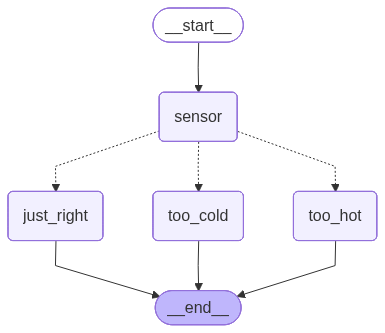

In [5]:
# 그래프 그리기
from IPython.display import Image, display
display(Image(temp_graph.get_graph().draw_mermaid_png()))

## Test

In [6]:
test_cases = [
    {"temperature": 35.0},  # 더움
    {"temperature": 10.0},  # 추움
    {"temperature": 22.0},  # 적정
]

for test_input in test_cases:
    print(f"\n{'=' * 50}")
    result = temp_graph.invoke(test_input)
    print(f"최종 상태: {result}")


[센서] 현재 온도: 35.0°C
[처리] 에어컨 켜기
최종 상태: {'temperature': 35.0, 'action': '에어컨 ON', 'result': '냉방 중'}

[센서] 현재 온도: 10.0°C
[처리] 히터 켜기
최종 상태: {'temperature': 10.0, 'action': '히터 ON', 'result': '난방 중'}

[센서] 현재 온도: 22.0°C
[처리] 쾌적한 온도입니다
최종 상태: {'temperature': 22.0, 'action': '유지', 'result': '적정 온도'}
